In [100]:
%matplotlib widget
import numpy as np
import matplotlib.pyplot as plt
from astropy.time import Time
import lightkurve as lk
from scipy.optimize import curve_fit
import pandas as pd
from scipy.interpolate import make_interp_spline as spline
import math

In [101]:
#Getting the lightcurve
TIC = 'TIC 3034524' 
data_all = lk.search_lightcurve(TIC, author='SPOC')
data = data_all[0]
lc = data.download_all().stitch()

#Extracting flux data from the light curve into x, y
Times = lc.time
t = Time(Times)
x = np.array(t.btjd)
y = np.array(lc.flux)
    
# Remove invalid values (infs and NaNs) from y and x arrays
mask_valid = ~np.isnan(y) & ~np.isinf(y)
x = x[mask_valid]
y = y[mask_valid]

#converting x and y to pandas dataframe
light_curve = pd.DataFrame({
    'time': x,
    'flux': y
})

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 33000 entries, 0 to 32999
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   x_fit   33000 non-null  float64
 1   y_fit   33000 non-null  float64
dtypes: float64(2)
memory usage: 515.8 KB


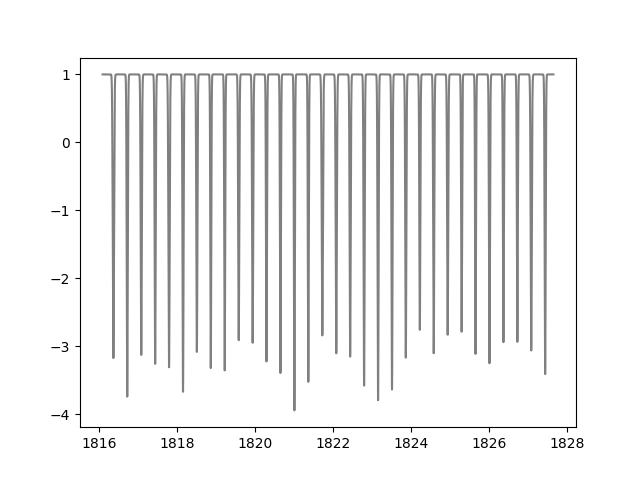

In [102]:
#Reads the fitted curve data 

fitted_curve = pd.read_csv('Data Files/fitted_curve.csv')
fitted_curve.info()

# Plot the fitted curve
plt.figure()
plt.plot(fitted_curve['x_fit'], fitted_curve['y_fit'], color='gray')

In [112]:
#FIND PEAKS
from scipy.signal import find_peaks

#invert the curve to find peaks
fitted_curve['inverted_y_fit'] = -fitted_curve['y_fit']

# Find peaks in the inverted_y_fit column
peaks, _ = find_peaks(fitted_curve['inverted_y_fit'], )

# Get the x_fit values corresponding to the peaks
peak_x_values = fitted_curve['x_fit'][peaks]
peak_x_values.reset_index(drop=True, inplace=True)

# Print the peak x_fit values
# print(peak_x_values)

# Calculate the periods, convert to series
periods = np.diff(peak_x_values)
periods_series = pd.Series(periods)

#Create a Dataframe with peaks and periods
peaks_n_periods = pd.DataFrame({'Period': periods_series, 'Peak_x_value': peak_x_values})
peaks_n_periods.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 32 entries, 0 to 31
Data columns (total 2 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   Period        31 non-null     float64
 1   Peak_x_value  32 non-null     float64
dtypes: float64(2)
memory usage: 644.0 bytes


We Have the following:

`light_curve`: A pandas.DataFrame, has the lightcurve and all the raw data in columns `time` and `flux`

`fitted_curve`: A pandas.DataFrame, has fitted Gaussian curve(s) with `x_fit`, `y_fit` & `inverted_y_fit`

`peak_x_values`: This is a pandas.Series object with all the times of peaks.

`periods`: An numpy.ndarray containing all the periods.

In [ ]:
#Plots the peaks as vertical lines
plt.figure()
plt.plot(fitted_curve['x_fit'], fitted_curve['y_fit'], color='gray')
for x in peak_x_values:
    plt.axvline(x=x, color='red', linestyle='--')

In [ ]:
#DEPRACATED??
#Get indices of the peaks
start_index = 0
i=1
begins = []
no_bins = 200

for row in peaks_n_periods.iterrows():
    period = row[1]['Period']
    peak = row[1]['Peak_x_value']
    bin_width = period/no_bins
    bin_begin = Time(peak, scale='tdb', format='btjd')
    print(bin_begin)
    for bin in range(no_bins):
        bin_end = bin_begin + bin_width
        begin_index = np.searchsorted(lc.time, bin_begin, side='right')
        end_index = np.searchsorted(lc.time, bin_end, side='right')
        
        # Get the flux values in the bin
        flux_in_bin = lc.flux[begin_index:end_index]
        print(len(flux_in_bin))
        begins.append(bin_begin)
        bin_begin = bin_end

In [118]:
from tqdm import tqdm
starts = np.empty(32)
ends = np.empty(32)
i = 0

for row in tqdm(peaks_n_periods.iterrows(), total=peak_x_values.shape[0]):
    period = row[1]['Period']
    peak = row[1]['Peak_x_value']
    starts[i] = np.searchsorted(lc.time, Time(peak, scale='tdb', format='btjd'), side='right')
    try:
        ends[i] = np.searchsorted(lc.time, Time((peak + period), scale='tdb', format='btjd'), side='right')
    except:
        ends[i] = 0
    i += 1

new_peaks_n_periods = pd.DataFrame({
    'Period' : peaks_n_periods['Period'],
    'Peak' : peaks_n_periods['Peak_x_value'],
    'Start' : pd.Series(starts),
    'End' : pd.Series(ends)
})


100%|██████████| 32/32 [01:12<00:00,  2.27s/it]


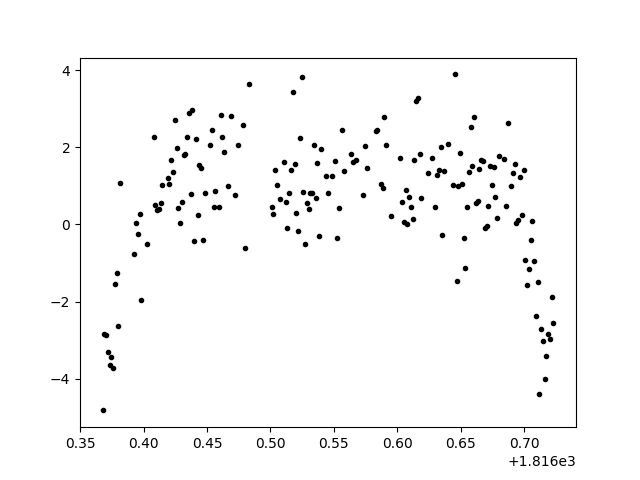

In [127]:
plt.figure()
light_curveee = light_curve[199:384]

plt.scatter(light_curveee['time'], light_curveee['flux'], marker='.', color='black')
plt.show()

In [186]:
no_bins = 200
sums = np.zeros(no_bins)
counts = np.zeros(no_bins)

In [187]:
#trying???

for row in tqdm(new_peaks_n_periods.iterrows(), total=new_peaks_n_periods.shape[0]):
    p = row[1]['Period']
    begin = row[1]['Peak']
    light = light_curve.copy(deep=True)[int(row[1]['Start']):int(row[1]['End'])]
    for light_row in tqdm(light.iterrows(), total = light.shape[0]):
        bin_number = math.floor(  (    (light_row[1]['time'] - begin)   /  p   ) * no_bins )
        sums[bin_number] += light_row[1]['flux']
        counts[bin_number] += 1

    

100%|██████████| 31/31 [00:00<00:00, 36.81it/s]


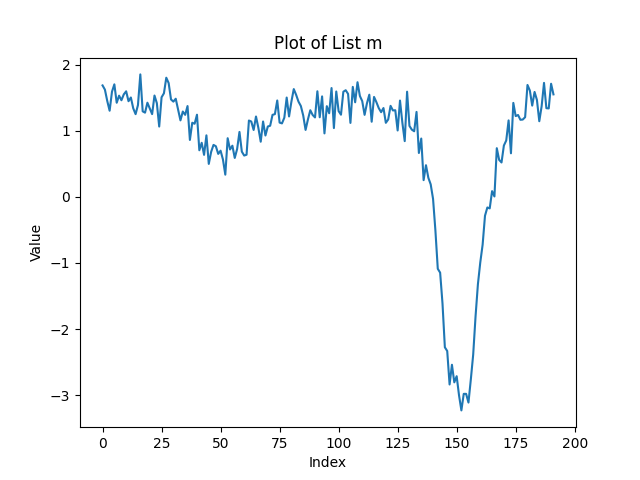

In [190]:
means = sums / counts
m = list(means)

m = m + m[0: int((0.2 * len(m)))]

import matplotlib.pyplot as plt

# Assuming 'm' is the list you want to plot
plt.figure()
plt.plot(m[int((0.2 * len(m))):])
plt.xlabel('Index')
plt.ylabel('Value')
plt.title('Plot of List m')
plt.show()

Made changes.

In [98]:
for x in begins:
    plt.axvline(x=x.btjd, color='green', linestyle='--')

In [76]:
lc.time

<Time object: scale='tdb' format='btjd' value=[1816.0897911  1816.09118004 1816.09256898 ... 1841.15108029 1841.15246915
 1841.15385801]>

In [31]:
bin_num = 10

bin_width = (2-1)/bin_num

initial = 1

for i in range(bin_num):
    nx = bin_width + initial
    #add all the ones inside
    initial = nx

initial


2.000000000000001